In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt


2023-12-03 22:25:05.723879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 22:25:06.048841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 22:25:06.051806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 22:25:07.043130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set the path to the dataset
dataset_path = '.'

# Set the paths to images and annotations
images_folder = os.path.join(dataset_path, 'Dataset')
annotations_folder = os.path.join(dataset_path, 'Bounding_Boxes')

# Set the number of classes
num_classes = 3

# Model configuration
input_shape = (512, 512, 3)  # Adjust based on your image size
batch_size = 32
epochs = 20

In [3]:
class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax, class_id, img_path):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.class_id = class_id
        self.img_path = img_path

    def __repr__(self):
        return f'[{self.xmin}, {self.ymin}, {self.xmax}, {self.ymax} | {self.class_id}]'


In [4]:
# Data preprocessing and loading
def load_data():
    images = []
    annotations = []
    label_map = {}

    # Open Bounding_Boxes/darknet.labels and read class names and put into label_map
    with open(os.path.join(annotations_folder, 'darknet.labels'), 'r') as f:
        class_names = f.readlines()
        for i, class_name in enumerate(class_names):
            label_map[i] = class_name.strip()

    # return images, labels
    for annotation_name in os.listdir(annotations_folder):

        # If no .txt files, continue
        if not annotation_name.endswith('.txt'):
            continue

        # Load image
        image_name = annotation_name.replace('.txt', '.jpg')
        image_path = os.path.join(images_folder, image_name)
        image = cv2.imread(image_path)
        image_width, image_height = image.shape[1], image.shape[0]
        image = cv2.resize(image, (input_shape[0], input_shape[1]))

        images.append(image)

        # Load annotations
        annotation_path = os.path.join(annotations_folder, annotation_name)
        with open(annotation_path, 'r') as f:
            # Parse bounding box coordinates and class label
            # Example format: class x_min y_min x_max y_max
            lines = f.readlines()
            sub_annotations = []
            for line in lines:
                line = line.strip().split(' ')
                class_label, x_min, y_min, x_max, y_max = map(float, line)

                # Convert normalized coordinates to absolute coordinates
                x_min *= image_width
                y_min *= image_height
                x_max *= image_width
                y_max *= image_height

                # Rescale coordinates to input_shape
                x_min = int(x_min * input_shape[0] / image_width)
                y_min = int(y_min * input_shape[1] / image_height)
                x_max = int(x_max * input_shape[0] / image_width)
                y_max = int(y_max * input_shape[1] / image_height)

                # Store annotation information
                sub_annotations.append(BoundingBox(x_min, y_min, x_max, y_max, int(class_label), image_path))

            annotations.append(sub_annotations)

    # images = np.array(images)

    return images, annotations, label_map


# Load and preprocess the data
images, annotations, label_map = load_data()

images, len(annotations), label_map


([array([[[ 27,  26, 136],
          [ 27,  26, 136],
          [ 27,  26, 136],
          ...,
          [ 32, 112, 243],
          [ 32, 112, 243],
          [ 32, 112, 243]],
  
         [[ 27,  26, 136],
          [ 27,  26, 136],
          [ 27,  26, 136],
          ...,
          [ 32, 112, 243],
          [ 32, 112, 243],
          [ 32, 112, 243]],
  
         [[ 27,  26, 136],
          [ 27,  26, 136],
          [ 27,  26, 136],
          ...,
          [ 32, 112, 243],
          [ 32, 112, 243],
          [ 32, 112, 243]],
  
         ...,
  
         [[ 27,  26, 136],
          [ 27,  26, 136],
          [ 27,  26, 136],
          ...,
          [ 65,  33, 160],
          [ 69,  36, 166],
          [ 76,  42, 176]],
  
         [[ 27,  26, 136],
          [ 27,  26, 136],
          [ 27,  26, 136],
          ...,
          [ 51,  30, 145],
          [ 68,  48, 157],
          [ 68,  50, 152]],
  
         [[ 27,  26, 136],
          [ 27,  26, 136],
          [ 27,  26, 136

In [5]:
annotations[0]


[[119, 206, 212, 129 | 2],
 [119, 303, 210, 63 | 2],
 [118, 369, 209, 68 | 2],
 [118, 426, 209, 44 | 2],
 [116, 471, 209, 45 | 2],
 [381, 45, 199, 50 | 2],
 [382, 94, 197, 45 | 2],
 [115, 156, 197, 19 | 0],
 [111, 280, 194, 13 | 0],
 [113, 348, 194, 18 | 0],
 [115, 418, 200, 19 | 0],
 [116, 461, 195, 20 | 0],
 [378, 38, 187, 19 | 0],
 [379, 82, 184, 17 | 0],
 [119, 170, 196, 8 | 1],
 [119, 178, 196, 8 | 1],
 [119, 186, 197, 8 | 1],
 [119, 194, 198, 9 | 1],
 [118, 202, 197, 7 | 1],
 [118, 210, 198, 7 | 1],
 [118, 217, 200, 8 | 1],
 [118, 225, 200, 7 | 1],
 [119, 233, 198, 8 | 1],
 [118, 241, 199, 7 | 1],
 [118, 248, 200, 8 | 1],
 [118, 256, 200, 7 | 1],
 [120, 293, 196, 10 | 1],
 [120, 302, 195, 7 | 1],
 [120, 310, 195, 7 | 1],
 [119, 317, 197, 7 | 1],
 [118, 325, 196, 7 | 1],
 [120, 363, 195, 9 | 1],
 [119, 371, 196, 7 | 1],
 [119, 379, 196, 8 | 1],
 [119, 387, 196, 7 | 1],
 [119, 395, 196, 9 | 1],
 [118, 432, 196, 7 | 1],
 [118, 439, 196, 7 | 1],
 [119, 477, 189, 9 | 1],
 [119, 485, 1

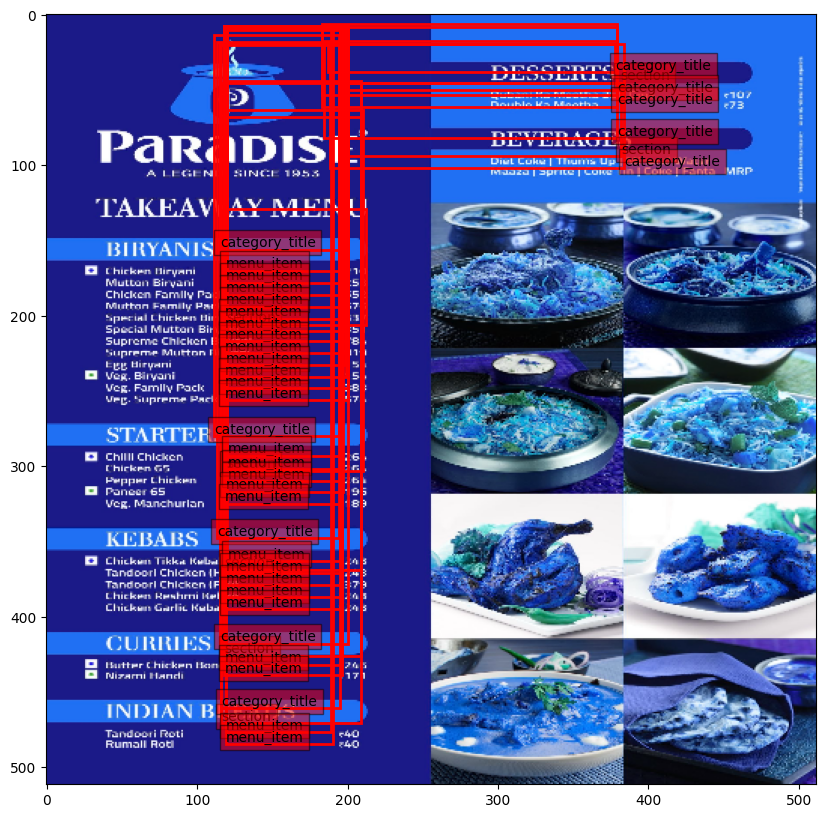

In [6]:
# Helper function to visualize bounding boxes
# It takes an image and a list of bounding boxes as inputs and plots an image with all the bounding boxes
# Each bounding box class should have a different color
def visualize_bounding_boxes(image, annotations):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        xmin, ymin, xmax, ymax, class_id = annotation.xmin, annotation.ymin, annotation.xmax, annotation.ymax, annotation.class_id

        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label_map[class_id], bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

visualize_bounding_boxes(images[0], annotations[0])
